### **Columbia University**
### **ECBM E4040 Neural Networks and Deep Learning. Fall 2021.**

## **Task 2: RNN application -- Tweet Sentiment Analysis**

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimenssionality redution. 

In [39]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data


In [40]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


In [111]:
np.where(vocabulary == "help")[0][0]

221

In [103]:
train_tweets[100]

array([  10,   53,  221, 2727,   41, 1418,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1])

## **Part 1 LSTM Encoder**

**TODO**: Create a single-layer LSTM network to classify tweets. Use one hot encoding to represent each word in the tweet. Set LSTM units to 100. Use Adam optimizer and set batch size to 64.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional). 

(tf.one_hot and Keras functional API may be useful).

In [44]:
num_tokens = len(vocabulary)
print(train_tweets[:2].shape)
l = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode="one_hot", sparse=False)
l(train_tweets[:2]).shape

(2, 20)


ValueError: Exception encountered when calling layer "category_encoding_16" (type CategoryEncoding).

When output_mode is not `'int'`, maximum supported output rank is 2. Received output_mode one_hot and input shape (2, 20), which would result in output rank 3.

Call arguments received:
  • inputs=tf.Tensor(shape=(2, 20), dtype=int32)
  • count_weights=None

In [22]:
train_tweets.shape

(60000, 20)

In [53]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################
num_tokens = len(vocabulary)

def one(in_, num_tokens):
    return tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode="one_hot", sparse=False)(in_)

input = tf.keras.layers.Input((20,))
print(input.shape)
# cat = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode="one_hot", sparse=False)(input_)
x = tf.keras.layers.Lambda(lambda i: one(i, num_tokens))(input)
X = tf.keras.layers.LSTM(100)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
den2 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(input, den2)


model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_tweets, 
                        train_labels, batch_size=64, epochs=50, validation_data=(test_tweets, test_labels))

###################################################
# END TODO                                        #
###################################################

(None, 20)


ValueError: Exception encountered when calling layer "category_encoding" (type CategoryEncoding).

When output_mode is not `'int'`, maximum supported output rank is 2. Received output_mode one_hot and input shape (None, 20), which would result in output rank 3.

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 20), dtype=float32)
  • count_weights=None

## **Part 2: Embedding Lookup layer**

**Define an embedding layer**

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling.

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

**TODO**: Define a similar model as above with one change. Use an Embedding layer instead of one hot embedding. Also, write a custom training loop to train the model instead of using model.fit(). Writing a custom loop gives you complete control over how the model is trained. Refer to the link below.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

Report loss and accuracy for training and validation after each epoch. Also, display the loss value after every 400 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?


Solution:

In [72]:
batch_size = 64

In [79]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_tweets, train_labels))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((test_tweets, test_labels))
val_dataset = val_dataset.batch(batch_size)

In [81]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################
vocab_len = len(vocabulary)
embed_dim = 128
lstm_out = 100

inputs = tf.keras.Input((20,))
print(input.shape)
embed = tf.keras.layers.Embedding(vocab_len, embed_dim, input_length=train_tweets.shape[1])(inputs)
print(embed.shape)
x = tf.keras.layers.SpatialDropout1D(0.4)(embed)
# print(x.shape)
x = tf.keras.layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)(x)
# print(x.shape)
x = tf.keras.layers.Dense(64,activation='relu')(x)
# print(x.shape)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
# print(x.shape)
den = tf.keras.layers.Dense(1, activation='sigmoid')(x)
print(den.shape)

model = tf.keras.Model(inputs, den)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 400 batches.
        if step % 400 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

###################################################
# END TODO                                        #
###################################################

(None, 20)
(None, 20, 128)
(None, 1)

Start of epoch 0
Training loss (for one batch) at step 0: 0.7483
Seen so far: 64 samples
Training loss (for one batch) at step 400: 0.6929
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 0.6937
Seen so far: 51264 samples
Training acc over epoch: 0.4975
Validation acc: 0.4879
Time taken: 32.15s

Start of epoch 1
Training loss (for one batch) at step 0: 0.6931
Seen so far: 64 samples
Training loss (for one batch) at step 400: 0.6788
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 0.6371
Seen so far: 51264 samples
Training acc over epoch: 0.6269
Validation acc: 0.6002
Time taken: 28.33s

Start of epoch 2
Training loss (for one batch) at step 0: 0.6879
Seen so far: 64 samples
Training loss (for one batch) at step 400: 0.5999
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 0.5941
Seen so far: 51264 samples
Training acc over epoch: 0.7271
Validation acc: 0.7328
Time taken: 53.79s

Start of

## **TODO:**  **Visualize word vectors via tSNE**

First, you need to retrieve embedding matrix from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector.

And then, you should visualize some interesting word pairs in 2D panel. You may find scatter function in matplotlib.pyplot useful.

Hint: You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.

In [97]:
word_embeddings = model.layers[1].get_weights()[0]

In [98]:
from sklearn.manifold import TSNE

In [100]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(word_embeddings)
X_embedded.shape

(7597, 2)

In [129]:
plt.style.use("seaborn-bright")

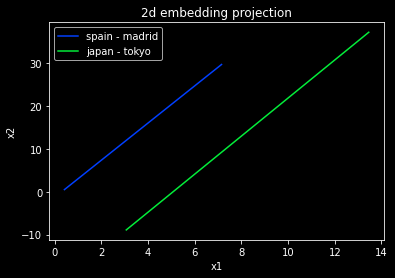

In [134]:
plt.plot(X_embedded[np.where(vocabulary == "spain")[0][0]], X_embedded[np.where(vocabulary == "madrid")[0][0]], label='spain - madrid')
plt.plot(X_embedded[np.where(vocabulary == "japan")[0][0]], X_embedded[np.where(vocabulary == "tokyo")[0][0]], label='japan - tokyo')
plt.title('2d embedding projection')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(loc="upper left")
plt.show()